In [81]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import set_config
from metrics import default_competition_metric
from metrics import make_competition_scorer, competition_scoring, ColumnSelector

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.compose import ColumnTransformer
import xgboost as xgb

set_config(display="text")
set_config(print_changed_only=True)


random.seed(10)

In [82]:
x_train = np.load("../data/x_train.npy")
y_train = np.load("../data/y_train.npy")


x_val = np.load("../data/x_val.npy")
y_val = np.load("../data/y_val.npy")

train_important = x_train[:, [102, 103, 105]]
val_important = x_val[:, [102, 103, 105]]
X_train = train_important

In [25]:
from sklearn.manifold import MDS

mds = MDS(
    n_components=1,
    random_state=21,
    n_init=10,
    normalized_stress=False,
    eps=0.0001,
    max_iter=600,
)
train_important_mds = mds.fit_transform(train_important)
test_important_mds = mds.fit_transform(val_important)

In [43]:
from sklearn.neighbors import KernelDensity

train_important_mds_for_kde = train_important_mds[y_train == 0].reshape(-1, 1)
kde = KernelDensity(kernel="gaussian", bandwidth=0.3).fit(train_important_mds_for_kde)

train_important_mds_for_kde_2 = train_important_mds[y_train == 1].reshape(-1, 1)
kde_2 = KernelDensity(kernel="gaussian", bandwidth=0.3).fit(
    train_important_mds_for_kde_2
)

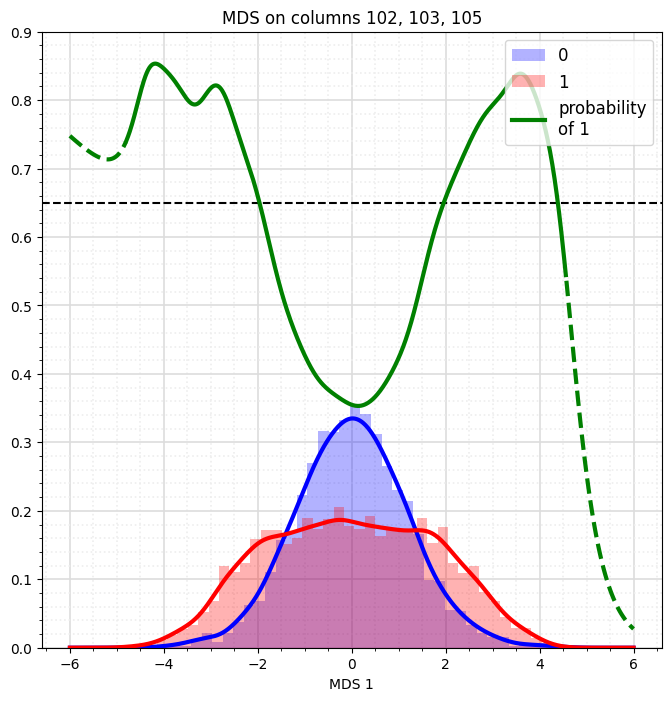

In [92]:
# make a histogram without sns
plt.figure(figsize=(8, 8))

plt.hist(
    train_important_mds[y_train == 0],
    color="blue",
    alpha=0.3,
    bins=40,
    label="0",
    linewidth=0,
    zorder=10,
    density=True,
)
plt.hist(
    train_important_mds[y_train == 1],
    color="red",
    alpha=0.3,
    bins=40,
    label="1",
    linewidth=0,
    zorder=10,
    density=True,
)

x = np.linspace(-6, 6, 1000)
y_0 = np.exp(kde.score_samples(x.reshape(-1, 1)))
y_1 = np.exp(kde_2.score_samples(x.reshape(-1, 1)))
plt.plot(
    x,
    y_0,
    color="blue",
    linewidth=3,
    zorder=11,
)

plt.plot(
    x,
    y_1,
    color="red",
    linewidth=3,
    zorder=11,
)

start = 100
end = 880
scaling_factor = 1

plt.plot(
    x[start:end],
    scaling_factor * y_1[start:end] / (y_0[start:end] + y_1[start:end]),
    color="green",
    linewidth=3,
    label="probability\nof 1",
    zorder=12,
)
plt.plot(
    x[:start],
    scaling_factor * y_1[:start] / (y_0[:start] + y_1[:start]),
    color="green",
    linewidth=3,
    zorder=12,
    linestyle="--",
)

plt.plot(
    x[end:],
    scaling_factor * y_1[end:] / (y_0[end:] + y_1[end:]),
    color="green",
    linewidth=3,
    zorder=12,
    linestyle="--",
)

plt.grid(which="major", color="#DDDDDD", linewidth=1.2)
plt.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=1.2)
plt.minorticks_on()
plt.xlabel("MDS 1")
plt.ylim(0, 0.9)
leg = plt.legend(fontsize="large", loc="upper right")
leg.set(zorder=13)
plt.title("MDS on columns 102, 103, 105")

# horizontal line
plt.axhline(0.65, color="black", linewidth=1.5, linestyle="--")

In [26]:
X_train_with_mds = np.concatenate([X_train, train_important_mds], axis=1)

In [44]:
seeds = [21, 22, 23, 24, 25, 5111, 23525, 34934, 343243]
res = []
for seed in seeds:
    cv_folds = 5
    np.random.seed(seed)
    idx = np.array(range(X_train.shape[0]))
    np.random.shuffle(idx)
    svm_results = []

    idx = idx % cv_folds
    for j in range(cv_folds):
        X_train_cv = X_train[idx != j]
        y_train_cv = y_train[idx != j]
        X_val_cv = X_train[idx == j]
        y_val_cv = y_train[idx == j]

        scaler = StandardScaler()
        X_train_cv = scaler.fit_transform(X_train_cv)
        X_val_cv = scaler.transform(X_val_cv)

        svm = SVC(probability=True, random_state=44, kernel="poly", degree=2)
        svm.fit(X_train_cv, y_train_cv)

        y_pred = svm.predict_proba(X_val_cv)[:, 1]
        score = default_competition_metric(y_val_cv, y_pred_proba=y_pred, k=3)

        svm_results.append(score)

    print(
        round(np.mean(svm_results)),
        "$   ",
        round(np.std(svm_results), 2),
        "$",
    )
    res.append(np.mean(svm_results))
print("mean", np.mean(res), "std", np.std(res))

7088 $    282.29 $
7000 $    322.59 $
7050 $    539.97 $
7125 $    423.16 $
7100 $    91.86 $
7075 $    377.91 $
7100 $    304.65 $
7062 $    242.38 $
7062 $    402.34 $
mean 7073.611111111111 std 34.07734485107027


In [37]:
seeds = [21, 22, 23, 24, 25, 5111, 23525, 34934, 343243]
res = []
for seed in seeds:
    cv_folds = 5
    np.random.seed(seed)
    idx = np.array(range(X_train.shape[0]))
    np.random.shuffle(idx)
    rf_results = []

    idx = idx % cv_folds
    for j in range(cv_folds):
        X_train_cv = X_train_with_mds[idx != j]
        y_train_cv = y_train[idx != j]
        X_val_cv = X_train_with_mds[idx == j]
        y_val_cv = y_train[idx == j]

        forest = RandomForestClassifier(
            n_estimators=400,
            max_depth=6,
            criterion="entropy",
            min_samples_leaf=10,
            random_state=21,
        )
        forest.fit(X_train_cv, y_train_cv)

        y_pred = forest.predict_proba(X_val_cv)[:, 1]

        score = default_competition_metric(y_val_cv, y_pred_proba=y_pred, k=3)

        rf_results.append(score)

    print(
        round(np.mean(rf_results)),
        "$   ",
        round(np.std(rf_results), 2),
        "$",
    )
    res.append(np.mean(rf_results))
print("mean", np.mean(res), "std", np.std(res))

6975 $    228.45 $
6988 $    175.0 $
6912 $    428.3 $
6938 $    235.85 $
6975 $    100.0 $
6950 $    334.01 $
6800 $    286.68 $
6912 $    277.83 $
6862 $    329.77 $
mean 6923.611111111111 std 57.265355911356394


## testing on validation set

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
val_important = scaler.transform(val_important)

svm = SVC(probability=True, random_state=44, kernel="poly", degree=2)
svm.fit(X_train, y_train)

y_pred = svm.predict_proba(val_important)[:, 1]

score = default_competition_metric(y_val, y_pred_proba=y_pred, k=3)
score

6500.0

Bruh

In [42]:
forest = RandomForestClassifier(
    n_estimators=400,
    max_depth=6,
    criterion="entropy",
    min_samples_leaf=10,
    random_state=21,
)
forest.fit(X_train_cv, y_train_cv)

y_pred = svm.predict_proba(val_important)[:, 1]

score = default_competition_metric(y_val, y_pred_proba=y_pred, k=3)
score

6550.0

In [80]:
best_params_mrmr = {
    "model__n_estimators": 800,
    "model__max_depth": 3,
    "model__learning_rate": 0.01,
    "model__colsample_bytree": 1,
    "feature_selection__columns": [102, 103, 105],
}
pipe.set_params(**best_params_mrmr)
pipe.fit(x_train, y_train)

y_proba = pipe.predict_proba(x_val)[:, 1]
competition_scoring(pipe, x_val, y_val, scale_metric=True)

6850.0

# different take 

## Final testing

### XGBoost

In [ ]:
cv_folds = 10
np.random.seed(45)
idx = np.array(range(X_train.shape[0]))
np.random.shuffle(idx)
xgb_results = []
y_val_cv_saved = []
xgb_predictions = []
xgb_proba = []


idx = idx % cv_folds
for j in range(cv_folds):
    X_train_cv = X_train[idx != j]
    y_train_cv = y_train[idx != j]
    X_val_cv = X_train[idx == j]
    y_val_cv = y_train[idx == j]
    y_val_cv_saved.append(y_val_cv)

    xgboost = xgb.XGBClassifier(
        n_estimators=1000,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.5,
        colsample_bytree=0.5,
        scale_pos_weight=1,
        n_jobs=4,
        random_state=44,
    )
    xgboost.fit(X_train_cv, y_train_cv)

    y_pred = xgboost.predict_proba(X_val_cv)[:, 1]
    xgb_proba.append(y_pred)
    score = default_competition_metric(
        y_val_cv, y_pred=y_pred, k=len(features), y_pred_proba=y_pred
    )

    n = len(y_pred)
    top_02 = np.argsort(y_pred)[::-1][: n // 5]
    print(y_pred[np.argsort(y_pred)[::-1][n // 5]])
    y_pred = np.zeros(n)
    y_pred[top_02] = 1

    xgb_predictions.append(y_pred)
    xgb_results.append(score)
print(np.mean(xgb_results), np.std(xgb_results))

0.77521616
0.8160193
0.820625
0.80577064
0.8468559
0.7836787
0.8096221
0.8064002
0.77308345
0.81777996
6162.5 469.2081094780865


### SVM

In [ ]:
svms = []
cv_folds = 10
np.random.seed(45)
idx = np.array(range(X_train.shape[0]))
np.random.shuffle(idx)
svm_results = []
svm_predictions = []
svm_proba = []


idx = idx % cv_folds
for j in range(cv_folds):
    X_train_cv = X_train[idx != j]
    y_train_cv = y_train[idx != j]
    X_val_cv = X_train[idx == j]
    y_val_cv = y_train[idx == j]

    scaler = StandardScaler()
    X_train_cv = scaler.fit_transform(X_train_cv)
    X_val_cv = scaler.transform(X_val_cv)

    svm = SVC(probability=True, random_state=44)
    svm.fit(X_train_cv, y_train_cv)
    svms.append(svm)

    y_pred = svm.predict_proba(X_val_cv)[:, 1]
    svm_proba.append(y_pred)
    score = default_competition_metric(
        y_val_cv, y_pred=y_pred, k=len(features), y_pred_proba=y_pred
    )

    n = len(y_pred)
    top_02 = np.argsort(y_pred)[::-1][: n // 5]
    print(y_pred[np.argsort(y_pred)[::-1][n // 5]])
    y_pred = np.zeros(n)
    y_pred[top_02] = 1

    svm_predictions.append(y_pred)
    svm_results.append(score)

print(np.mean(svm_results), np.std(svm_results))

0.6914981905553738
0.7275946172171822
0.7048743888009285
0.7241478734301225
0.7147481725248302
0.7189878405750321
0.6859822370657577
0.714332792475627
0.6864721405736913
0.6828365517365638
6612.5 494.50101112131205


In [ ]:
avg_sum_xgb = []
avg_sum_svm = []
avg_combined = []
for svm, xgb, real in zip(svm_predictions, xgb_predictions, y_val_cv_saved):
    sum_xgb = np.sum(xgb * real) / sum(xgb)
    sum_svm = np.sum(svm * real) / sum(svm)
    combined = np.sum(svm * xgb * real) / sum(svm * xgb)
    avg_sum_xgb.append(sum_xgb)
    avg_sum_svm.append(sum_svm)
    avg_combined.append(combined)

print("xgb", np.mean(avg_sum_xgb), np.std(avg_sum_xgb))
print("svm", np.mean(avg_sum_svm), np.std(avg_sum_svm))

print(np.mean(avg_combined), np.std(avg_combined))

xgb 0.7362500000000001 0.046920810947808665
svm 0.78125 0.049450101112131196
0.7712383094206451 0.05845488944598688


In [ ]:
svm_proba = np.concatenate(svm_proba)
xgb_proba = np.concatenate(xgb_proba)
y_val_cv_saved = np.concatenate(y_val_cv_saved)

Text(0, 0.5, 'Count')

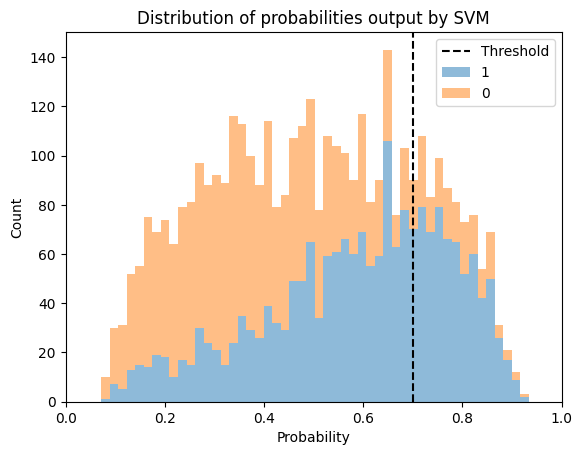

In [ ]:
svm_proba_pos = svm_proba[y_val_cv_saved == 1]
xgb_proba_pos = xgb_proba[y_val_cv_saved == 1]
svm_proba_neg = svm_proba[y_val_cv_saved == 0]
xgb_proba_neg = xgb_proba[y_val_cv_saved == 0]

# plt.hist(svm_proba_pos, bins=50, alpha=0.5, label="1")
# plt.hist(svm_proba_neg, bins=50, alpha=0.5, label="0")
plt.hist([svm_proba_pos, svm_proba_neg], bins=50, alpha=0.5, stacked=True)
plt.axvline(x=0.7, color="black", linestyle="--", label="Threshold")
plt.xlim(0, 1)
plt.legend(["Threshold", "1", "0"])
plt.title("Distribution of probabilities output by SVM")
plt.xlabel("Probability")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

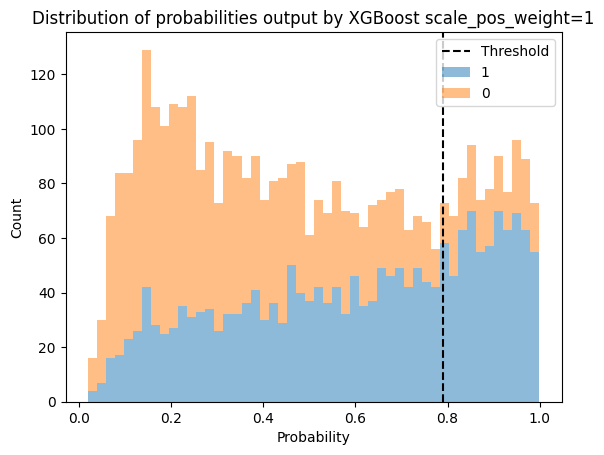

In [ ]:
# plt.hist(xgb_proba_pos, bins=50, alpha=0.5, label="1")
# plt.hist(xgb_proba_neg, bins=50, alpha=0.5, label="0")
plt.hist([xgb_proba_pos, xgb_proba_neg], bins=50, alpha=0.5, stacked=True)
plt.axvline(x=0.79, color="black", linestyle="--", label="threshold")
plt.legend(["Threshold", "1", "0"], loc="upper right")
plt.title("Distribution of probabilities output by XGBoost scale_pos_weight=1")
plt.xlabel("Probability")
plt.ylabel("Count")
# plot vertical line at x = 0.79